# Assignment — Community Detection

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from zlib import adler32
from IPython.display import clear_output


In this assignment, we try to detect communities in Les Miserables graph.

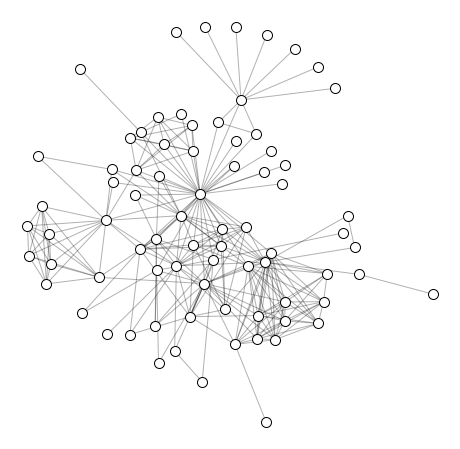

In [2]:
G = nx.Graph()
G.add_edges_from(nx.les_miserables_graph().edges)
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color='white', edgecolors='black', node_size=100)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.show()

### Task 1. Girvan Newman algorithm (0.8 point)

Let us apply Girvan Newman algorithm with edge betweenness. The idea is we cut edges with highest betweenness until the graph becomes disconnected. Use `nx.algorithms.community.girvan_newman` to find communities.

Write a function `edge_betweenness` that takes a graph and the number of divisions and returns np.array of (integer) labels of nodes in each iteration. The shape of the output is [n, m] where n is a number of iteration and m is a number of nodes.

In [3]:
def edge_betweenness(G, n):
    # YOUR CODE HERE
    # raise NotImplementedError()
    divisions = nx.algorithms.community.girvan_newman(G)
    results = []
    for k, item in enumerate(divisions):
        if k < n:
            data = []
            for node in G.nodes:
                for i, group in enumerate(item):
                    if node in group:
                        data.append(i)
            results.append(data)
    return np.array(results)

In [4]:
labels = edge_betweenness(G, 6)
assert labels.shape == (6, 77)
assert np.unique(labels[0]).shape == (2,)
assert np.unique(labels[0]).shape[0] < np.unique(labels[1]).shape[0] < np.unique(labels[5]).shape[0]
assert labels[5][22] == labels[5][23]
assert labels[5][31] == labels[5][34]

Let us draw Girvan Newman algorithm step-by-step.

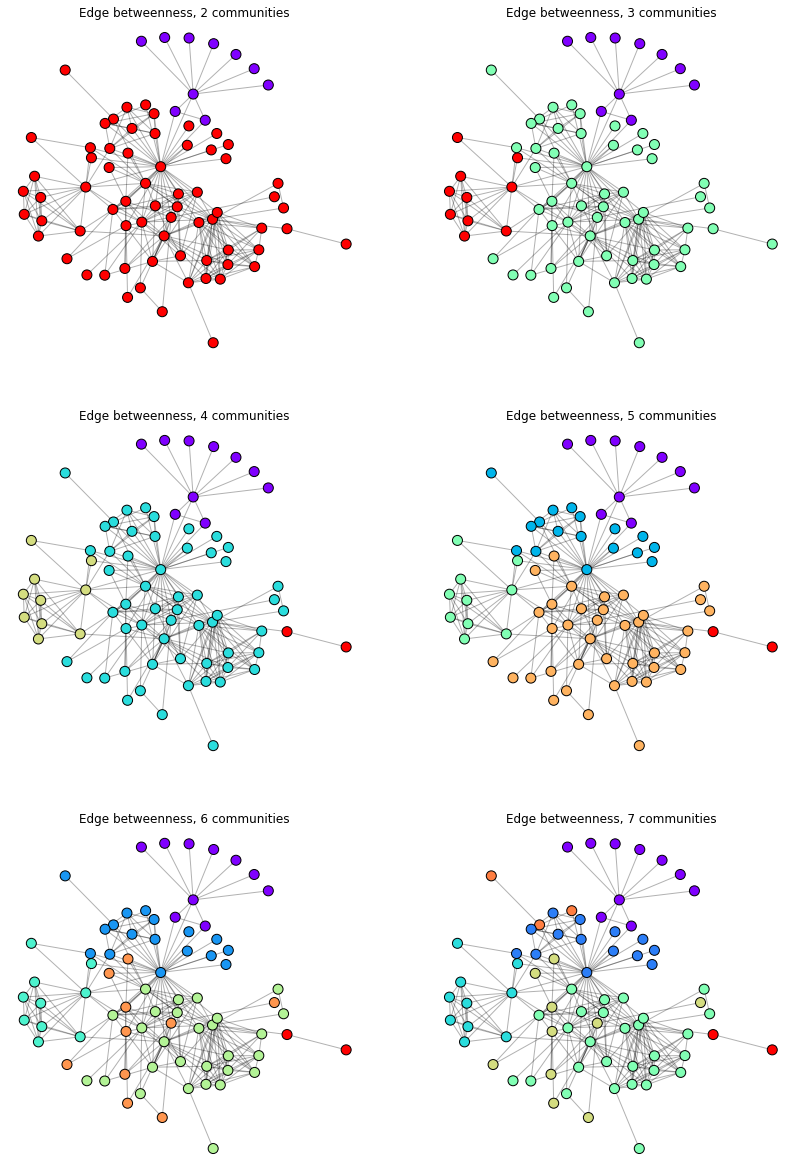

In [5]:
plt.figure(figsize=(7*2, 7*3))
colors = edge_betweenness(G, 6)
for i in range(colors.shape[0]):
    plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        G, 
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors[i], 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.title('Edge betweenness, {} communities'.format(i+2))
    plt.axis('off')

### Task 2. Modularity (1 point)

Modularity helps to decide when to stop splitting the graph. The large modularity, the better partitioning. Let us see how modularity changes during division.

Write a function `edge_betw_modularity` that takes a graph, number of iterations of Girvan Newman algorithm and returns a np.array with modularity after each iteration. Use `nx.algorithms.community.modularity`.

In [6]:
def edge_betw_modularity(G, n):
    # YOUR CODE HERE
    # raise NotImplementedError()
    divisions = nx.algorithms.community.girvan_newman(G)
    communities = None
    result = []
    for _ in range(n):
        communities = next(divisions, None)
        if communities is None:
            break
        m = nx.algorithms.community.modularity(G, communities)
        result.append(m)
    return np.array(result)

In [7]:
n_iterations = 20
modularity = edge_betw_modularity(G, n_iterations)
assert modularity.shape == (n_iterations, )
assert round(modularity[0], 4) == 0.0746
assert round(modularity[7], 4) == 0.4519

Let us draw dependency between a number of iteration and modularity.

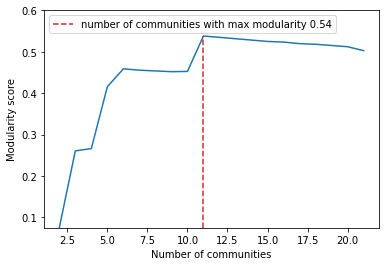

In [8]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(n_iterations)+2, modularity)
best_n = np.argmax(modularity) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(modularity))
plt.plot(
    [best_n, best_n], [min(modularity), max(modularity)], 
    'k--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.ylim((modularity.min(), 0.6))
plt.show()

### Task 3. Eigenvalues of graph Laplacian (0.8 point)

There are a few auxiliary methods for graph generation.

In [9]:
def ring_lattice(n, k):
    G = nx.Graph()
    nodes = list(range(n))
    for i in range(1, int(k/2 + 1)):
        targets = nodes[i:] + nodes[:i]
        G.add_edges_from(zip(nodes, targets))
    return G

In [10]:
def pair_graph(n):
    G = nx.disjoint_union(nx.complete_graph(n), nx.complete_graph(n))
    G.add_edge(0, n)
    return G

In [11]:
def triple_graph(n):
    G = nx.disjoint_union_all(
        [nx.complete_graph(n), nx.complete_graph(n), nx.complete_graph(n)]
    )
    G.add_edge(0, n)
    G.add_edge(n, n*2)
    G.add_edge(n*2, 0)
    return G

Graph Laplacian is

$$L = D - A$$

where $A$ is an adjacency matrix and $D$ is a diagonal matrix with node degrees. Eigenvalues and eigenvectors of Laplacian can give us information about structure of a graph. Let us see a few simple examples.

Write a function `eig_laplacian` that takes a graph and returns a tuple with 2 np.arrays: eigenvectors and eigenvalues of Laplacian. The both are ordered in ascending of eigenvalues. 

_Hints: any symmetric matrix has only real eigenvalues and eigenvectors. You can use `np.linalg.eigh` to calculate eigenvectors and eigenvalues in a symmetric matrix._

In [12]:
def eig_laplacian(G):
    # YOUR CODE HERE
    # raise NotImplementedError()
    A = nx.to_numpy_array(G)
    D = np.diag(A.sum(axis=0))
    L = D - A
    vals, vecs = np.linalg.eigh(L)


    # D = np.eye(len(G))
    # degrees = np.array(
    #     [value for key, value in dict(G.degree).items()]
    # )
    # D = D*degrees
    # A = nx.adjacency_matrix(G)
    # eigval, eigvec = np.linalg.eigh(D - A)
    return vecs, vals

In [13]:
emptyG = nx.empty_graph(10)
vecs, vals = eig_laplacian(emptyG)
assert vecs.sum() == 10
assert vals.sum() == 0
oneedgeG = nx.empty_graph(10)
oneedgeG.add_edge(0, 1)
vecs, vals = eig_laplacian(oneedgeG)
assert abs(vecs.round(4)[0, -1]) == abs(vecs.round(4)[1, -1]) == 0.7071
assert vals[0] < vals[-1]
vecs, vals = eig_laplacian(nx.complete_graph(10))
assert (vals == vals.real).sum() == vals.shape[0]
assert (vecs == vecs.real).sum() == vals.shape[0]**2
vecs, vals = eig_laplacian(ring_lattice(10, 2))
assert adler32(vals.round(4)[-1]) == 6815825
assert adler32(vals.round(4)[-2]) == 393479360

Consider some simple graphs and their Laplacian eigenvalues.

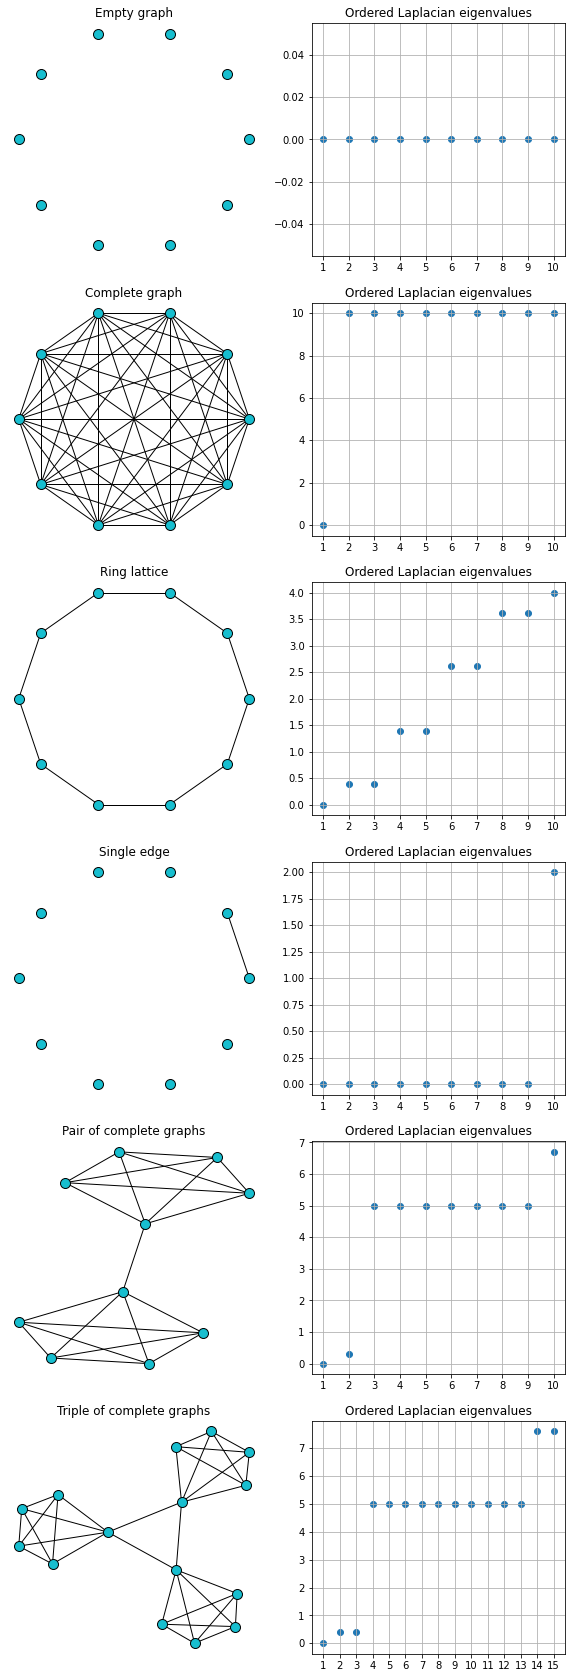

In [14]:
cases = []
cases.append([emptyG, 'Empty graph', nx.draw_circular])
cases.append([nx.complete_graph(10), 'Complete graph', nx.draw_circular])
cases.append([ring_lattice(10, 2), 'Ring lattice', nx.draw_circular])
cases.append([oneedgeG, 'Single edge', nx.draw_circular])
cases.append([pair_graph(5), 'Pair of complete graphs', nx.draw_kamada_kawai])
cases.append([triple_graph(5), 'Triple of complete graphs', nx.draw_kamada_kawai])

plt.figure(figsize=(5*2, 5*6))
i = 1
for iterG, title, designer in cases:
    plt.subplot(6, 2, i)
    i += 1
    designer(iterG, 
             node_color='tab:cyan', 
             edgecolors='black', 
             node_size=100)
    plt.title(title)
    plt.subplot(6, 2, i)
    i += 1
    vecs, vals = eig_laplacian(iterG)
    plt.scatter(np.arange(1, len(iterG) + 1), vals)
    plt.grid()
    plt.xticks(np.arange(1, len(iterG) + 1))
    plt.title('Ordered Laplacian eigenvalues')

We can observe that a number of zero eigenvalues is a number of connected component. $\lambda_2 = n$ in a complete graph. Also, the largest gap between eigenvalues indicates an optimal number of clusters. For example, the largest gap in a complete graph is between 1 and 2, then an optimal number of clusters is 1. Similarly, 2-3 gap is related to a pair graph, and 3-4 gap is related to a triple graph.

### Task 4. Spectral clustering (0.7 point)

Spectral clustering is a very powerful algorithm for community detection that minimize graph cuts. It is based on Laplacian eigenvectors, in particular a sign of the second smallest eigenvector determines the partition of a graph into two clusters. Consider the following artificial dataset.

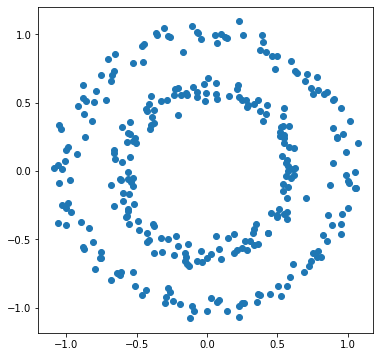

In [15]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1])
plt.show()

Let us isolate data points in center circle using spectral clustering. Any distance based dataset can be represented as a graph with edges between neighbors.

Write a function `custom_graph` that takes a np.array with x-y data points and returns a connected graph. 

_Hint: try to apply `sklearn.neighbors.kneighbors_graph`._

_Remark: you can introduce your own distance_

In [16]:
# from sklearn.neighbours import 
from sklearn.neighbors import kneighbors_graph
def custom_graph(data):
    # YOUR CODE HERE
    # raise NotImplementedError()
    from sklearn.neighbors import kneighbors_graph
    A = kneighbors_graph(data, n_neighbors=10).toarray()
    return nx.Graph(A)

In [17]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
circlesG = custom_graph(circles)
assert circlesG.number_of_nodes() == 300
assert nx.is_connected(circlesG)

Let us draw values in second smallest eigenvector of Laplacian.

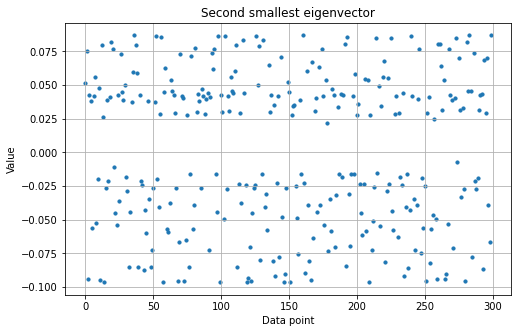

In [18]:
vecs, vals = eig_laplacian(circlesG)

plt.figure(figsize=(8, 5))
plt.scatter(np.arange(300), vecs[:, 1], s=10)
plt.title('Second smallest eigenvector')
plt.xlabel('Data point')
plt.ylabel('Value')
plt.grid()
plt.show()

Next, write a function `spectral_two_clusters` that takes np.array with ordered eigenvectors and returns np.array with labels of nodes.

In [19]:
def spectral_two_clusters(vecs):
    # YOUR CODE HERE
    # raise NotImplementedError()
    return np.sign(vecs[:,1])

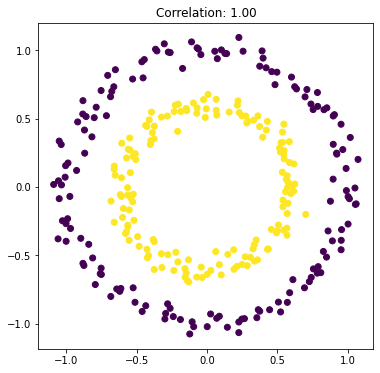

In [20]:
circles, truth_labels = datasets.make_circles(n_samples=300, factor=0.6, 
                                              noise=0.05, random_state=0)
circlesG = custom_graph(circles)
vecs, vals = eig_laplacian(circlesG)
labels = spectral_two_clusters(vecs)

assert abs(np.corrcoef(truth_labels, labels)[0, 1]) > 0.95

plt.figure(figsize=(6, 6))
plt.scatter(circles[:, 0], circles[:, 1], c=labels)
plt.title('Correlation: {:.2f}'.format(abs(np.corrcoef(truth_labels, labels)[0, 1])))
plt.show()

_Remark: there are two directions of graph construction: selection pairs of nodes to connect to each other, and choosing the weights of created edges. Set `factor=0.7` in `datasets.make_circles` and test yourself — try to achive 0.9 correlation. Combine `sklearn.neighbors.kneighbors_graph` with `scipy.spatial.distance_matrix` or `sklearn.metrics.pairwise.rbf_kernel`. Details are [here](http://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf)._

### Task 5. Laplacian Eigenmaps (1.5 points)

In the previous task, we saw how to split a graph into two parts. Let us consider a way to get more parts in the following graph.

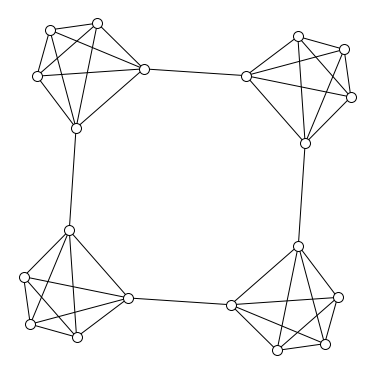

In [21]:
quadG = nx.disjoint_union_all([nx.complete_graph(5), 
                               nx.complete_graph(5),
                               nx.complete_graph(5),
                               nx.complete_graph(5)])
quadG.add_edge(0, 5)
quadG.add_edge(6, 10)
quadG.add_edge(11, 16)
quadG.add_edge(17, 1)

plt.figure(figsize=(5, 5))
nx.draw_kamada_kawai(
    quadG, 
    node_color='white', 
    edgecolors='black', 
    node_size=100)

Further splitting can be performed by different approaches. For example, we can repeat the clustering procedure on the both subgraphs separetely and choose a minimal graph cut and then repeat it again. Another way is to get Laplacian Eigenmaps and then apply KMeans. Let us consider how it works.

1. Compute normalized Laplacian
$$L = D^{-1/2}(D - A)D^{-1/2}$$
2. Stack eigenvectors $L$ into the matrix $(x_1, x_2, \dots)$ in ascending order of eigenvalues
3. Multiply i-th row by $\frac{1}{\sqrt{d_i}}$ where $d_i$ is a node degree
* $k$ vectors of the matrix starting from the second one is _Laplacian Eigenmaps (Spectral Embedding)_
4. Put eigenmaps into KMeans
5. Label nodes by fitted KMeans

Write a function `norm_laplacian` that takes an adjacency matrix `A` and returns a tuple with 2 np.arrays. The first is a normalized Laplacian, the second is a degree sequence.

In [22]:
def norm_laplacian(A):
    # YOUR CODE HERE
    # raise NotImplementedError()
    # A = nx.to_numpy_array(G)
    # D = np.diag(A.sum(axis=0))
    # D_pow = np.diag(D.d)
    # A = nx.to_numpy_array(G)
    D = np.diag(A.sum(axis=0))
    D_pow = np.diag(D.diagonal()**(-1/2))
    return D_pow@(D-A)@D_pow, D.diagonal()


In [23]:
A = nx.to_numpy_array(quadG)
L, degree_seq = norm_laplacian(A)
assert degree_seq.shape == (20, )
assert L.shape == (20, 20)
assert np.diagonal(L).sum() == 20
assert round(L[:, 2].sum(), 4) == 0.0528

Write a function `spectral_embedding` that takes np.array with normalized Laplacian, np.arrays with degree sequence and returns np.array with Laplacian Eigenmaps. `n_components` is a number of vectors of the output.

In [24]:
def spectral_embedding(L, degree_seq, n_components):
    # YOUR CODE HERE
    # raise NotImplementedError()
    degree_seq_pow = degree_seq**(-1/2)
    # eigval, eigvec = np.linalg.eig(L,)
    eigval, eigvec = np.linalg.eigh(L)
    # eigval = eigval.real
    # eigvec = eigvec.real
    idx = eigval.argsort()
    eigval = eigval[idx]
    eigvec = eigvec[:,idx]
    # print(eigval)
    R = np.real(eigvec*degree_seq_pow[:,None])
    return R[:,1:(n_components+1)]
# (embedding[:, 0] > 0).sum()
# embedding
# labels

In [25]:
embedding = spectral_embedding(L, degree_seq, 3)
assert embedding.shape == (20, 3)
assert embedding[:, 0].max() > 0
assert embedding[:, 0].min() < 0
assert embedding[:, 1].max() > 0
assert embedding[:, 1].min() < 0
assert (embedding[:, 0] > 0).sum() == 10
assert (embedding[:, 1] > 0).sum() == 10
assert (embedding[:, 2] > 0).sum() == 10

Let us look at a pairplot of the spectral embedding.

In [26]:
def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L, degree_seq = norm_laplacian(A)
    embedding = spectral_embedding(L, degree_seq, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

In [27]:
embedding = spectral_embedding(L, degree_seq, 3)
labels = spectral_clustering(quadG, 4, 3)
assert np.all(labels[:5] == labels[0])
assert np.all(labels[5:10] == labels[5])
assert np.all(labels[10:15] == labels[10])
assert np.all(labels[15:20] == labels[15])

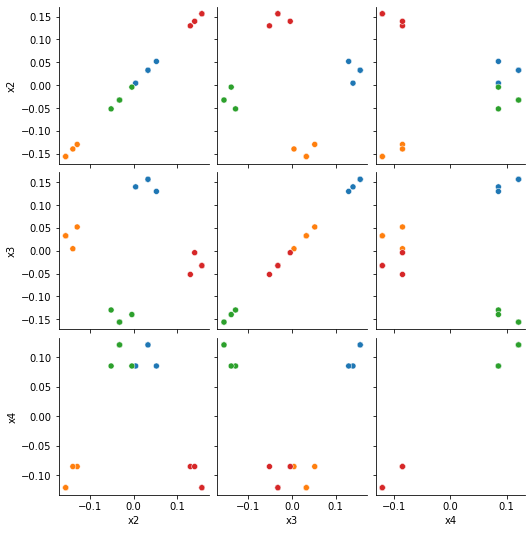

In [28]:
embedding = spectral_embedding(L, degree_seq, 3)
labels = spectral_clustering(quadG, 4, 3)
pair_data = pd.DataFrame(
    np.hstack([embedding, labels[:, None]]), 
    columns=['x2', 'x3', 'x4', 'label'])
pair_data.label = pair_data.label.astype('str')
p = sns.pairplot(
    pair_data,
    hue='label',
    diag_kind=None
)
p._legend.remove()
plt.show()

We can see four distinct clusters in the plots, that is why we use KMeans, but other clustering algorithms can also be applied here.

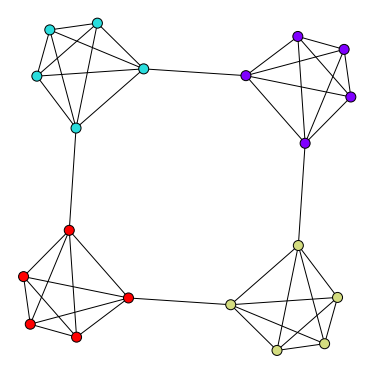

In [29]:
plt.figure(figsize=(5, 5))
nx.draw_kamada_kawai(
    quadG, 
    cmap=plt.cm.rainbow,
    node_color=labels, 
    edgecolors='black', 
    node_size=100)

Finally, let us see how spectral clustering works on the Les Miserables graph.

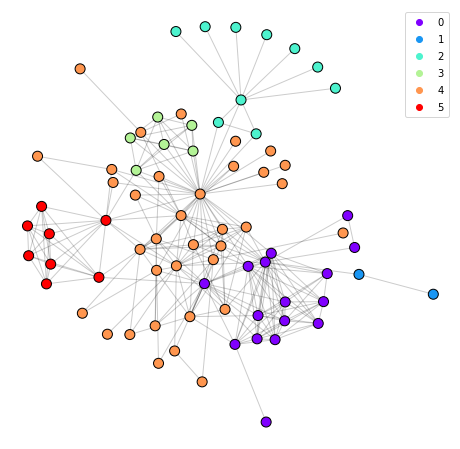

In [30]:
plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=spectral_clustering(G, 6, 5), 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.legend(*nodes.legend_elements())
plt.show()

### Task 6. Agglomerative clustering (1.5 points)

Agglomerative clustering is an iterative procedure that unions similar clusters using a similarity matrix, but since we will run `sklearn.cluster.AgglomerativeClustering`, we need to pass a _distance_ matrix. So, first we need to choose a similarity measure and then convert it into a distance. Let us do it via SimRank measure that is defined as follows: _two objects are considered to be similar if they are referenced by similar objects_. Since SimRank takes values on the interval [0, 1], let us define a distance as

$$\text{Distance}= 1 - \text{SimRank}$$

Write a function `simrank_distance` that takes a graph and returns a distance matrix based on SimRank. Use `nx.simrank_similarity_numpy`. The distance matrix should be _absolutely_ symmetric.

In [31]:
def simrank_distance(G):
    # YOUR CODE HERE
    # raise NotImplementedError()
    R = 1 - nx.simrank_similarity_numpy(G)
    return R.astype(np.float32) #(R+R.T)/2


In [32]:
distance = simrank_distance(G)
assert distance.shape == (77, 77)
assert np.diagonal(distance).sum() == 0
assert np.allclose(distance, distance.T, rtol=0, atol=0)
assert distance[52, 68] <= distance[1, 19]
assert distance[45, 29] <= distance[38, 46]

Then let us cluster nodes using `scipy.cluster.hierarchy.linkage`. The method takes distancies and returns an np.array with a matrix `Z` where every i-th row consists of
* `Z[i, 0]` and `Z[i, 1]` are indexes of combined clusters
* `Z[i, 2]` is the distance between combined clusters
* `Z[i, 3]` is the number of observations in combined clusters

Cluster with an index `n+i` is described in a i-th row of the matrix `Z`. Clusters with indexes less than `n+1` are initial nodes. The method `scipy.cluster.hierarchy.dendrogram` uses the matrix `Z` to plot a dendrogram. Let us look at a dendrogram of Les Miserables graph.

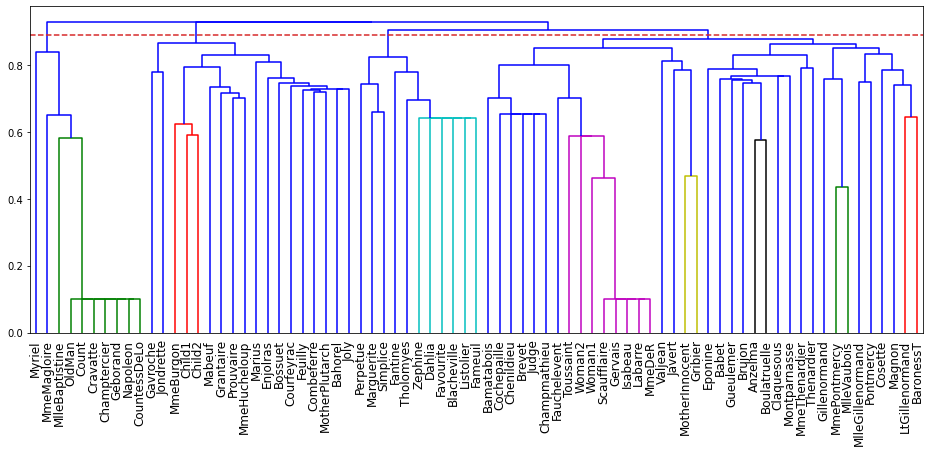

In [33]:
plt.figure(figsize=(16, 6))
linked = linkage(squareform(distance), 'complete')
dendrogram(linked, labels=list(G.nodes), 
           leaf_font_size=12)
plt.plot([0, 800], [0.89, 0.89], 'k--', c='tab:red')
plt.show()

Then we need to select a horizontal line that gives us a partitioning of the graph. There are two approaches: select the number of clusters, and select the maximal distance between clusters. For example, if we select a horicontal line with maximal distance 0.89 (a red line on the plot) then the number of clusters will be 4.

Write a function `agglomerative_clustering` that takes a distance matrix, maximal distance between clusters and returns an np.array with labels of clusters. Use `sklearn.cluster.AgglomerativeClustering` with complete linkage.

In [34]:
def agglomerative_clustering(distance, max_distance):
    # YOUR CODE HERE
    # raise NotImplementedError()
    # linked = linkage(squareform(distance), 'complete')
    est = AgglomerativeClustering(
        n_clusters=None,
        affinity='precomputed',
        distance_threshold=max_distance,
        linkage="complete"
    )
    return est.fit_predict(distance)
# AgglomerativeClustering(linkage="complete",
#     connectivity=distance,distance_threshold=0.89
# )
# linkage(squareform(distance), 'complete')
# from scipy.cluster.hierarchy import fcluster

# # set(fcluster(linked, 0.89))

# est = AgglomerativeClustering(
#     # affinity="manhattan",
#     affinity='precomputed',
#     n_clusters=None,
#     distance_threshold=0.8,
#     linkage="complete",
# )#.fit_transform(distance)
# len(set(est.fit_predict(distance)))

# distance>0.89
# linkage(squareform(distance), 'complete')
# obj = dendrogram(linked, labels=list(G.nodes), leaf_font_size=12, no_plot=True)
# obj.keys()
# distance.min(), distance.max()

In [35]:
assert len(set(agglomerative_clustering(distance, 0.8))) == 17
assert len(set(agglomerative_clustering(distance, 0.89))) == 4

On the graph with maximal distance 0.87

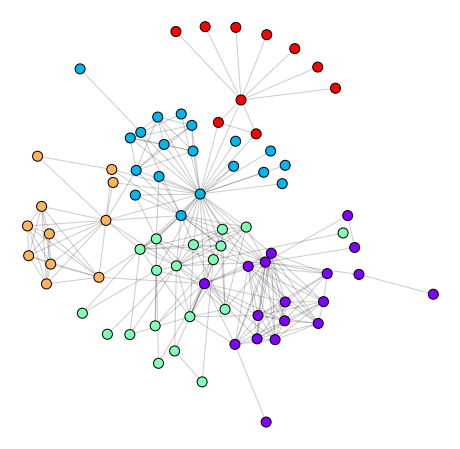

In [36]:
labels = agglomerative_clustering(distance, 0.87)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    G, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    G,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.show()

In [37]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from zlib import adler32

### Task 7. Louvain method (0.7 point)

Louvain method is one of the mostcited works in the community detection literature. It is a simple method to extract the community structure of large networks. This method is a heuristic method that is based on modularity optimization. Let us consider this method on a fractal graph that can represent some biological structure.

In [38]:
def fractal_graph(n, k, G):
    if k == 0:
        return G
    for node in list(G.nodes):
        newG = nx.complete_graph(n)
        newG = nx.relabel_nodes(newG, {node:max(G.nodes)+node+1 for node in newG.nodes})
        G = nx.union(G, newG)
        for edge in G.edges(node):
            G.add_edge(list(G.nodes)[-1], edge[1])
        G.remove_node(node)
    return fractal_graph(n, k-1, G)

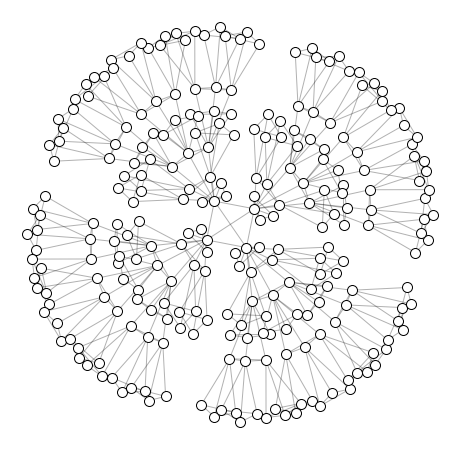

In [39]:
n = 4
fractalG = fractal_graph(n, 3, nx.complete_graph(n))

plt.figure(figsize=(8, 8))
frac_pos = nx.kamada_kawai_layout(fractalG)
nx.draw_networkx_nodes(fractalG, frac_pos, node_color='white', 
                       edgecolors='black', node_size=100)
nx.draw_networkx_edges(fractalG, frac_pos, alpha=0.3)
plt.axis('off')
plt.show()

Louvain method is a greedy algorithm of modularity gain that is described as: 

Phase 1
1. Put each node in its own community
2. For every node, calculate modularity gain by removing it from its community and placing it in neighbor's community
3. Put a node in the community with maximal modularity gain
4. Repeat 2, 3 until modularity stops increasing

Phase 2
1. Merge communities into ”super nodes”
2. Convert edges inside community into self loop, edges between communities into parallel edges

Repeat phases 1, 2 until modularity stops increasing.

In [40]:
def louvain_method(G):
    
    # Phase 1
    communities = unfolded_communities(G)
    labels = []
    for node in G.nodes:
        for i, c in enumerate(communities):
            if node in c:
                labels.append(i)
    
    # Phase 2
    nextG = nx.empty_graph(len(communities), nx.MultiGraph)
    for e in G.edges:
        for i in range(len(communities)):
            for j in range(len(communities)):
                if e[0] in communities[i] and e[1] in communities[j]:
                    nextG.add_edge(i, j)
                    
    # Shuffle colors for better visualization
    palette = np.unique(labels)
    key = np.random.permutation(palette)
    labels = key[np.digitize(labels, palette, right=True)]
    
    return communities, labels, nextG

Write a function `unfolded_communities` that takes a graph, performs Phase 1 and returns np.array of communities with nodes. For example, if there are two communitites: the first is [1,2] and the second is [3,4,5] then the output will be [[1,2],[3,4,5]].

In [41]:
def unfolded_communities(G):
    # Proposed template:
    communities = [[n] for n in G.nodes] # initial partition
    prev_max_modularity = -np.inf
    max_modularity = nx.algorithms.community.modularity(G, communities)
    while max_modularity > prev_max_modularity:
        prev_max_modularity = max_modularity
        for node in np.random.permutation(G.nodes):
            '''
            1) Remove the node from the initial community.
            2) Iterate all neighboring communities and move the node
               into a community with the maximum modularity gain. If 
               there is no modularity gain, return the node into the 
               initial community.
            '''
            # YOUR CODE HERE
            # raise NotImplementedError()
            for initial_comm in communities:
                if node in initial_comm:
                    initial_comm.remove(node)
                    break
            best_community = None
            for comm in communities:
                if not set(comm).intersection(G.neighbors(node)):
                    continue
                comm.append(node)
                modularity = nx.algorithms.community.modularity(G, communities)
                comm.pop()
                if modularity > max_modularity:
                    max_modularity = modularity
                    best_community = comm
            if best_community is not None:
                best_community.append(node)
            else:
                initial_comm.append(node)
    return [c for c in communities if len(c)]

In [42]:
n = 4
fractalG = fractal_graph(n, 2, nx.complete_graph(n))
iterG = fractalG.copy()
communities, labels, nextG = louvain_method(iterG)

assert len(set(labels)) == 16
assert len(set(labels[52:56])) == 1
assert len(set(labels[52:57])) == 2
assert nextG.number_of_nodes() == 16
assert round(np.linalg.det(nx.to_numpy_array(nextG)) * 1e-10, 4) == 136.5257

Let us see unfolding iterations. For every iteration we draw a graph where node color corresponds to the unfolded community.

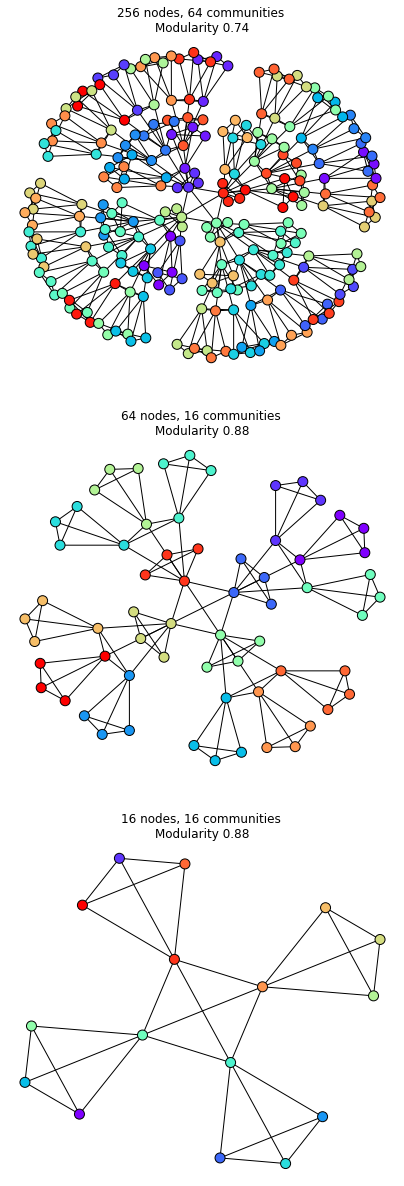

In [43]:
n = 4
fractalG = fractal_graph(n, 3, nx.complete_graph(n))
iterG = fractalG

plt.figure(figsize=(7, 7*3))
for i in range(3):
    plt.subplot(3, 1, i+1)
    communities, labels, nextG = louvain_method(iterG)
    iter_pos = nx.kamada_kawai_layout(iterG)
    nodes = nx.draw_networkx_nodes(
        iterG,
        iter_pos,
        cmap=plt.cm.rainbow,
        node_color=labels,
        edgecolors='black',
        node_size=100)
    nx.draw_networkx_edges(
        iterG,
        iter_pos,
        node_size=100)
    plt.axis('off')
    plt.title(
        '{} nodes, {} communities \nModularity {:.2f}'.format(
            len(iterG), len(communities), nx.community.modularity(iterG, communities)))
    iterG = nextG

### Task 8. Ego-Splitting (1.5 points)

Ego-Splitting is a framework for detecting clusters in complex networks which leverage the local structures known as ego-nets (i.e. the subgraph induced by the neighborhood of each node) to detect overlapping clusters. Ego-splittng is a highly scalable and flexible framework, with provable theoretical guarantees, that reduces the complex overlapping clustering problem to a simpler and more amenable non-overlapping (partitioning) problem.

Let us consider the algorithm on this small graph.

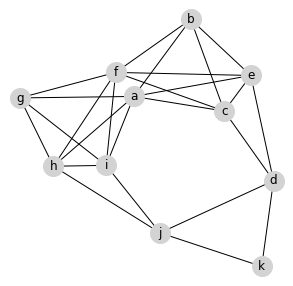

In [44]:
adjlist = [
    'a b c e h g i',
    'f b c e h g i',
    'b e c',
    'g i h',
    'e c d',
    'c d',
    'i h j',
    'h j',
    'j d k',
    'd k'
]
G = nx.parse_adjlist(adjlist)
plt.figure(figsize=(5, 5))
nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), 
                 node_size=400, node_color='lightgray')
plt.axis('off');

The ego-splitting algorithm processes a graph $G = (V, E)$ and outputs a set of clusters $S$ as follows:
1. For each node $u$ we use the local clustering algorithm to partition the ego-net of $u$.
2. Create a set $V'$ of personas. Each node $u$ in $V$ will correspond to $t_u$ personas in $V'$.
3. Add edges between personas.
4. Apply the global clustering algorithm.

![](https://raw.githubusercontent.com/netspractice/network-science/main/assignment_communities_2/ego_splitting.png)

In [45]:
def ego_splitting(graph):
    ego_nets = generate_ego_nets(graph)
    persona_graph = generate_persona_graph(ego_nets)
    return persona_clustering(personaG)

Write a function `generate_ego_nets` that takes a graph and returns a dictionary where keys are nodes and values are their ego-nets:

`{'a': ego-net of the node a, 'b': ego-net of the node b, ...}`

Ego-net *does not* include the ego-node.

*Hint: use `nx.ego_graph`*

In [46]:
def generate_ego_nets(graph):
    # YOUR CODE HERE
    # raise NotImplementedError()
    result = dict()
    for n in graph.nodes.keys():
      subgraph = nx.ego_graph(graph, n)
      if subgraph.has_node(n):
          subgraph.remove_node(n)
      result[n] = subgraph
    return result


In [47]:
ego_nets = generate_ego_nets(G)
assert set(ego_nets.keys()) == {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'}
assert set(ego_nets['d'].nodes) == {'c', 'e', 'j', 'k'}
assert set(ego_nets['f'].nodes) == {'b', 'c', 'e', 'g', 'h', 'i'}

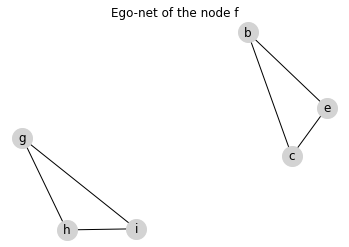

In [48]:
nx.draw_networkx(ego_nets['f'], pos=nx.kamada_kawai_layout(G), 
        node_color='lightgray', node_size=400)
plt.title('Ego-net of the node f')
plt.axis('off')
plt.show()

Next, we need to split each ego-net using any clustering method. Let it be the simple connected component detection method. 

In [49]:
def ego_clustering(graph):
    return [cc for cc in nx.connected_components(graph)]

Write a function `generate_persona_graph` that takes an ego-net dictionary and returns a persona graph:
1. Apply ego clustering for each ego-net.
2. Add a replica of the ego-node into each cluster and link it to each member. If there is more than one cluster then the replica name is the node name + cluster index. For example, if the ego-net `a` has clusters `[b, c]` and `[d]` then we add edges `[a0, b]`, `[a0, c]` and `[a1, d]`. Otherwise, the replica name is the node name.
3. Union all ego-nets into persona graph. Remove all nodes that has replicas. For example, if the graph has nodes `a`, `a0`, `a1`, then remove the node `a`.

In [82]:
def generate_persona_graph(ego_nets):
    # YOUR CODE HERE
    # raise NotImplementedError()
    results = []
    nodes_del = set()
    for n, ego_net in ego_nets.items():
        clusters = ego_clustering(ego_net)
        if 
        for idx, cc in enumerate(clusters):
            cluster = nx.Graph(ego_net.subgraph(cc))
            # print(cc, cluster)
            nodes = list(cluster.nodes)
            n1 = f"{n}{idx}"
            cluster.add_node(n1)
            nodes_del.add(n)
            for n2 in nodes:
                cluster.add_edge(n1, n2)
            results.append(cluster)
    result = nx.compose_all(results)
    result.remove_nodes_from(nodes_del)
    return result
# nx.draw(ego_nets['a'])
# nx.compose_all?
# G.subgraph({'a','g'})
# nx.draw(personaG,with_labels=True)
# G.re
# set(personaG.nodes)

{'a0',
 'a1',
 'b0',
 'c0',
 'd0',
 'd1',
 'e0',
 'f0',
 'f1',
 'g0',
 'h0',
 'i0',
 'j0',
 'j1',
 'k0'}

In [81]:
ego_nets = generate_ego_nets(G)
personaG = generate_persona_graph(ego_nets)
assert set(personaG.nodes) == {'i', 'f0', 'k', 'c', 'd0', 'a0', 'g', 'j0', 'e', 'h', 'd1', 'a1', 'j1', 'f1', 'b'}
assert {i[0] for i in personaG.neighbors('k')} == {'d', 'j'}
assert {i[0] for i in personaG.neighbors('g')} == {'a', 'f', 'h', 'i'}

AssertionError: ignored

Finally, we need to apply any clustering algorithm for the persona graph. Let it again be the simple connected component detection algorithm. Also, here we remove the cluster indexes from node names.

In [ ]:
def persona_clustering(graph):
    communities = [cc for cc in nx.connected_components(graph)]
    for c in communities:
        for node in c:
            c.remove(node)
            c.add(node[0])
    return communities

In [ ]:
plt.figure(figsize=(15, 5))
pos = nx.kamada_kawai_layout(G)
c_colors = ['tab:orange', 'tab:blue', 'tab:green']
for i, c in enumerate(ego_splitting(G)):
    plt.subplot(1, 3, i+1)
    color = []
    for node in G.nodes:
        color.append(c_colors[i] if node in c else 'white')
    nx.draw_networkx(G, pos=pos, node_color=color, 
                     edgecolors='black', node_size=400)
    plt.axis('off')
    plt.title('Colored nodes are in the community {}'.format(i+1))

### Task 9. Label propogation (1.5 points)

The label propogation method is based on the simple idea: every node is initialized with a unique label and at every step each node adopts the label that most of its neighbors currently have.

Write a function `update_labels` that takes a graph, np.array with labels in order `graph.nodes` and returns new labels. Label of the node is the random label occurring with the highest frequency among neighbors at the previous step. The order in which all the n nodes in the network are updated at each iteration is chosen randomly.

In [115]:
from collections import Counter

def update_labels(graph, labels):
    # YOUR CODE HERE
    # raise NotImplementedError()
    res = []
    for node in graph.nodes:
        # l = np.random.choice(list(graph.neighbors(node)))
        # res.append(l)
        counter = Counter(list(graph.neighbors(node)))
        comm = [l for l, _ in counter.most_common() if l in labels]
        if comm:
            res.append(comm[0])
    return np.array(res)
new_labels, labels
# Counter.most_common?

(array([1, 0, 0, 0, 0]), array([1, 0, 0, 0, 0]))

In [114]:
G = nx.karate_club_graph()
labels = np.array(list(G.nodes)) # initial partition
new_labels = update_labels(G, labels)
assert new_labels.shape == (34, )
assert len(set(new_labels)) < len(set(labels))
G = nx.star_graph(4)
labels = np.array(list(G.nodes)) # initial partition
for _ in range(5):
    labels = update_labels(G, labels)
new_labels = update_labels(G, labels)
assert len(set(new_labels - labels)) == 2
assert np.sum(list(set(new_labels - labels))) == 0

AssertionError: ignored

In [ ]:
def plot_propogation(G, update_method, n=50):
    pos=nx.kamada_kawai_layout(G)
    labels = np.array(list(G.nodes))
    for i in range(n):
        clear_output(wait=True)
        labels = update_method(G, labels)
        plt.figure(figsize=(6, 6))
        nx.draw_networkx_nodes(G, pos=pos, node_color=labels, cmap=plt.cm.tab10_r)
        nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
        nx.draw_networkx_labels(G, pos=pos)
        plt.axis('off')
        plt.title('Iteration {}/{}'.format(i+1, n))
        plt.show()

In [ ]:
plot_propogation(nx.karate_club_graph(), update_labels)

The problem however is that subgraphs in the network that are bi-partite or nearly bi-partite in structure lead to oscillations of labels.  This is especially true in cases where communities take the form of a star graph.

In [ ]:
plot_propogation(nx.star_graph(30), update_labels, 10)

Hence we need to use asynchronous updating where some neighbors have already been updated in the current iteration while some neighbors are not yet updated in the current iteration.

Write a function `async_update_labels` that make asynchronous label updating. The order in which all the n nodes in the network are updated at each iteration is chosen randomly.

In [ ]:
def async_update_labels(graph, labels):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
G = nx.karate_club_graph()
labels = np.array(list(G.nodes)) # initial partition
new_labels = async_update_labels(G, labels)
assert new_labels.shape == (34, )
assert len(set(new_labels)) < len(set(labels))
G = nx.star_graph(4)
labels = np.array(list(G.nodes)) # initial partition
for _ in range(5):
    labels = async_update_labels(G, labels)
new_labels = async_update_labels(G, labels)
assert np.all(new_labels - labels == 0)

In [ ]:
plot_propogation(nx.star_graph(30), async_update_labels, 10)

In [ ]:
plot_propogation(nx.karate_club_graph(), async_update_labels, 30)